In [1]:
import os
import cv2
import glob
import numpy as np
import networkx as nx
print('networkx verion : {}'.format(nx.__version__))
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
data_yes = glob.glob('.\\brain_tumor_dataset\\yes\\*.jpg')
data_no = glob.glob('.\\brain_tumor_dataset\\no\\*.jpg')

IMAGE_SIZE = 32
images, labels = [], []

print('Converting Positive Label Images : \n')
for img_path in tqdm(data_yes, total=len(data_yes)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    images.append(img / 255.)
    labels.append(1)

print('\nConverting Negative Label Image : \n')
for img_path in tqdm(data_no, total=len(data_no)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    images.append(img / 255.)
    labels.append(0)

images = np.asanyarray(images)
labels = np.asanyarray(labels)

networkx verion : 1.11
Converting Positive Label Images : 



  0%|          | 0/154 [00:00<?, ?it/s]


Converting Negative Label Image : 



  0%|          | 0/91 [00:00<?, ?it/s]

In [2]:
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph

def _grid_coordinates(side):
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z

def _get_adj_from_data(X, k, **kwargs):
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))
    return A

def _mnist_grid_graph(k):
    X = _grid_coordinates(IMAGE_SIZE)
    A = _get_adj_from_data(X, k, mode='connectivity', metric='euclidean', include_self=False)
    return A

def _flip_random_edges(A, percent):
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool_)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=2021)
print('X_train : {}'.format(X_train.shape))
print('X_test : {}'.format(X_val.shape))
print('y_train : {}'.format(y_train.shape))
print('y_test : {}'.format(y_val.shape))

X_train : (220, 32, 32, 3)
X_test : (25, 32, 32, 3)
y_train : (220,)
y_test : (25,)


In [4]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_pixels_images_data(images, labels):
    plt.figure(figsize=(15, 15))
    for i in tqdm(range(2)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(8):
            plt.subplot(8, 8,i*8+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.gray)
            plt.xlabel(lbls[j])
    plt.tight_layout()
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

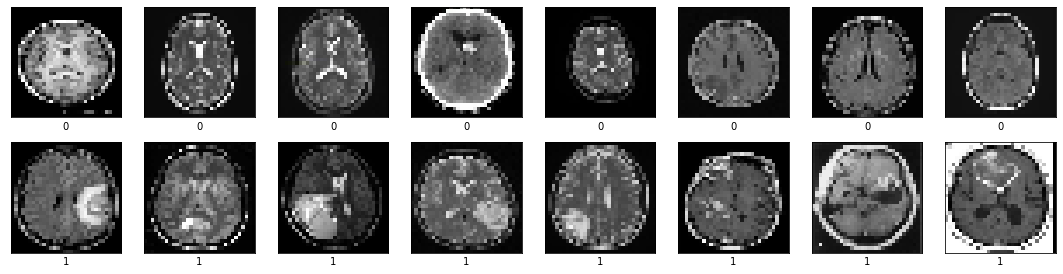

In [5]:
plot_pixels_images_data(X_train, y_train)

In [6]:
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.spring_layout, draw_labels=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'black'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]

    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='s', node_size=20, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [7]:
import os
import torch
from tqdm.auto import tqdm
from torch_geometric.data import Data, Dataset

class ImageGridDataset(Dataset):
    def __init__(self, root, test=False, transform=None, pre_transform=None, k=8, noise_level=0.0):
        self.test = test
        self.k = k
        self.noise_level = noise_level
        super(ImageGridDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return 'ImagesSuperpixels.pt'

    @property
    def processed_file_names(self):
        if self.test:
            return [f'data_test_{i}.pt' for i in range(len(X_val))]
        else:
            return [f'data_{i}.pt' for i in range(len(X_train))]

    def download(self):
        pass

    def process(self):
        if self.test:
            for i, j in tqdm(enumerate(X_val), total=len(X_val)):
                adj = _mnist_grid_graph(k=self.k)
                adj = _flip_random_edges(adj, self.noise_level).astype(np.float32)
                adj = adj.nonzero()
                adj = np.array(adj)
                x = j.flatten().reshape(IMAGE_SIZE*IMAGE_SIZE, -1)
                # Create Data Object
                data = Data(x=torch.tensor(x, dtype=torch.float),
                            edge_index=torch.tensor(adj).t().to(torch.long).reshape(2, -1),
                            y=torch.tensor([y_val[i]], dtype=torch.int64))

                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_test_{i}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_{i}.pt'))
        else:
            for i, j in tqdm(enumerate(X_train), total=len(X_train)):
                adj = _mnist_grid_graph(k=self.k)
                adj = _flip_random_edges(adj, self.noise_level).astype(np.float32)
                adj = adj.nonzero()
                adj = np.array(adj)
                x = j.flatten().reshape(IMAGE_SIZE*IMAGE_SIZE, -1)
                # Create Data Object
                data = Data(x=torch.tensor(x, dtype=torch.float),
                            edge_index=torch.tensor(adj).t().to(torch.long).reshape(2, -1),
                            y=torch.tensor([y_train[i]], dtype=torch.int64))

                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_test_{i}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'brain_tumor_data_{i}.pt'))

    def len(self):
        if self.test:
            return len(X_val)
        else:
            return len(X_train)

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'brain_tumor_data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'brain_tumor_data_{idx}.pt'))
        return data

In [8]:
train_dataset = ImageGridDataset(root='data/brain_tumor_graph/')

Processing...


  0%|          | 0/220 [00:00<?, ?it/s]

Done!


In [9]:
test_dataset = ImageGridDataset(root='data/brain_tumor_graph/', test=True)

Processing...


  0%|          | 0/25 [00:00<?, ?it/s]

Done!


In [10]:
test_dataset[1]

Data(x=[1024, 3], edge_index=[2, 8332], y=[1])

In [11]:
train_dataset[0].x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [12]:
train_dataset[0].edge_index.t()

tensor([[   0,  512],
        [   1,  448],
        [   0,  512],
        ...,
        [ 543, 1021],
        [ 511, 1023],
        [ 575, 1022]])

In [13]:
from torch_geometric.data import DataLoader
NUM_GRAPHS_PER_BATCH = 2
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

C:\Users\firqa\AppData\Roaming\Python\Python38\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [14]:
next(iter(train_loader))

DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])

In [15]:
next(iter(test_loader))

DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])

In [16]:
for step, data in enumerate(train_loader):
    if (step + 1) == 6:
        break
    print(f'Step {step + 1}:')
    print('=================')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print(data.x.shape)
    print(data.y.shape)

Step 1:
Number of graphs in the current batch: 2
DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])
torch.Size([2048, 3])
torch.Size([2])
Step 2:
Number of graphs in the current batch: 2
DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])
torch.Size([2048, 3])
torch.Size([2])
Step 3:
Number of graphs in the current batch: 2
DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])
torch.Size([2048, 3])
torch.Size([2])
Step 4:
Number of graphs in the current batch: 2
DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])
torch.Size([2048, 3])
torch.Size([2])
Step 5:
Number of graphs in the current batch: 2
DataBatch(x=[2048, 3], edge_index=[2, 16664], y=[2], batch=[2048], ptr=[3])
torch.Size([2048, 3])
torch.Size([2])


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Flatten
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(train_dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.flatten = Flatten()
        self.lin = Linear(hidden_channels, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.flatten(x)
        x = F.dropout(x, p=0.5, training=self.training)

        return F.log_softmax(self.lin(x), dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device :', str(device).upper())
model = GCN(hidden_channels=embedding_size).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 25)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        out = model(data.x.pin_memory().to(device), data.edge_index.pin_memory().to(device), data.batch.pin_memory().to(device))
        loss = criterion(out, data.y.pin_memory().to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x.pin_memory().to(device), data.edge_index.pin_memory().to(device), data.batch.pin_memory().to(device))
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.pin_memory().to(device)).sum())
    return correct / len(loader.dataset)

for epoch in range(0, 300):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

device : CUDA
GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
)
Epoch: 000, Train Acc: 0.6364, Test Acc: 0.5600
Epoch: 001, Train Acc: 0.6864, Test Acc: 0.5600
Epoch: 002, Train Acc: 0.6636, Test Acc: 0.5600
Epoch: 003, Train Acc: 0.6727, Test Acc: 0.5600
Epoch: 004, Train Acc: 0.6909, Test Acc: 0.5600
Epoch: 005, Train Acc: 0.5636, Test Acc: 0.6000
Epoch: 006, Train Acc: 0.5273, Test Acc: 0.5600
Epoch: 007, Train Acc: 0.7500, Test Acc: 0.7600
Epoch: 008, Train Acc: 0.7227, Test Acc: 0.7200
Epoch: 009, Train Acc: 0.5909, Test Acc: 0.6400
Epoch: 010, Train Acc: 0.7182, Test Acc: 0.8000
Epoch: 011, Train Acc: 0.7136, Test Acc: 0.6400
Epoch: 012, Train Acc: 0.4545, Test Acc: 0.5200
Epoch: 013, Train Acc: 0.7273, Test Acc: 0.8000
Epoch: 014, Train Acc: 0.7091, Test Acc: 0.7200
Epoch: 015, Train Acc: 0.7182, Test Acc: 0.6400
Epoch: 016, Train Acc: 0.